In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os

# Computer Science marks

This notebook will be analyzing marks from computer science papers (specifically those from the University of Otago!). We have data from the previous four years (2019-2022). This data was taken from Freedom of Information requests to the University of Otago, specifically from [this request](https://fyi.org.nz/request/21065-mark-distribution-of-papers#incoming-80077) and [this request](https://fyi.org.nz/request/22139-mark-distribution-for-200-and-300-level-cosc-and-info-papers#incoming-83891).

We start by taking the given `.xlsx` files (see the `RawDataFiles` directory) and manually stripping the data out into a more usable `.csv` format (see `data/papers`). This is the most tedious part of the project - as we must extract individual tables and add labels for years and semesters.

We have data on the number of students that achieved each mark (as a number) for each paper. Therefore, we could analyze the distribution of those marks and see if there is a deviation across different years for the same paper, or aggregated across all papers for that year.

With these files, we can load the data into pandas DataFrames. We can also load some aggregated data into a separate DataFrame so we can investigate some relationships across all papers. For example, because all papers have a PaperCode in the form of `COSCXYZ` where X, Y, and Z are digits, and X representing the year level of the paper, we could aggregate the marks for each year level to see if marks improve as students move through their degree.

In [2]:
# Define the directory for the data files
dataDirectory = "data"
# Define the subdirectory (within the dataDirectory) that holds the papers csv files
papersDataDirectory = os.path.join(dataDirectory, "papers")

# Define columns that indicate an instance of a paper
# A unique combination of theses is a single paper
groupbyColumns = ["Year", "Semester"]

# Aggregate data on papers
allPapers = pd.DataFrame()

# Collect all paper dataframes into a single dictionary, keyed by the papercode
papersdfs = {}

for filepath in os.listdir(papersDataDirectory):
    # Get the papercode (from the file name)
    filename = os.path.splitext(filepath)[0]
    # Load the data frame and put it into our paperdfs map
    paperData = pd.read_csv(os.path.join(papersDataDirectory, filepath))
    papersdfs[filename] = paperData

    # Get some base data for each instance of this paper
    # We use unique values of Year and Semester as this indicates an instance
    uniquePaperInstance = paperData[groupbyColumns].drop_duplicates()
    baseData = {
        "PaperCode": [],
        "Year": [],
        "Semester": [],
        "Level": [],
    }
    for _, row in uniquePaperInstance.iterrows():
        baseData["PaperCode"].append(filename)
        baseData["Year"].append(row["Year"])
        baseData["Semester"].append(row["Semester"])
        baseData["Level"].append(f"{filename[-3]}00")
    currentPaper = pd.DataFrame.from_dict(baseData)
    
    # Aggregate number of students over each instance of this paper
    numberOfStudentsAggregation = paperData[[*groupbyColumns, "Number of Students"]].groupby(groupbyColumns).aggregate(np.sum).reset_index()
    currentPaper["TotalStudents"] = numberOfStudentsAggregation["Number of Students"]

    # Aggregate the average mark over each instance of this paper
    averageMarkAggregation = paperData[[*groupbyColumns, "Mark"]].copy()
    averageMarkAggregation["Mark"] = pd.to_numeric(averageMarkAggregation["Mark"], errors="coerce")
    averageMarkAggregation = averageMarkAggregation.dropna()
    if len(averageMarkAggregation) > 0:
        averageMarkAggregation = averageMarkAggregation.groupby(groupbyColumns).aggregate([np.average, "sem"]).reset_index()
        currentPaper["AverageMark"] = averageMarkAggregation["Mark"]["average"]
        currentPaper["MarkSampleErrorOfMean"] = averageMarkAggregation["Mark"]["sem"]

    allPapers = pd.concat([allPapers, currentPaper])

allPapers = allPapers.sort_values(by="PaperCode")
allPapers.to_csv(os.path.join(dataDirectory, "allPapers.csv"))

## Total Number of Students Per Paper

Let's have a look at the number of students in each paper and in each year!

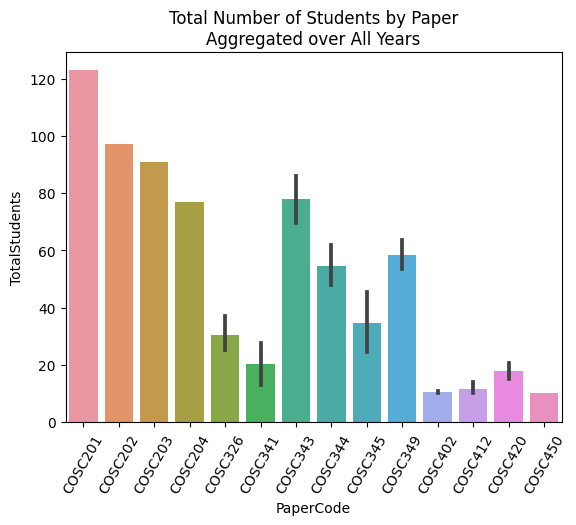

In [3]:
sns.barplot(allPapers, x="PaperCode", y="TotalStudents")
plt.title(f"Total Number of Students by Paper\nAggregated over All Years")
plt.xticks(rotation=60)
plt.show()

It appears at a cursory glance that the 200 level papers have a higher number of students than the 300 level papers, which in turn have a higher number of students than the 400 level papers. This seems reasonable, as we expect the number f students to fall off as the degree continues (for example, it is relatively common for students to drop out part way through a degree, not enrolling in higher level papers, compared to students suddenly attending high level papers without completing the prerequisites). This, of course, assumes that the number of students across the years is roughly constant, so the pipeline of students moving through the paper levels is unaffected by time. This is probably not true (the university grows over time, roughly with population!) but is reasonable in the timeframe we are analyzing. We should look more closely at the number of students by year level.

We also notice that not all papers have an associated error bar. This is due to some papers only having one instance in the data. For example, at the time of data collection, the 200 level papers (`COSC201`, `COSC202`, `COSC203`, `COSC204`) have only run once, as they are new! This is not ideal, but it is still interesting enough to analyze.

It appears that the 200 level papers have some drop off from semester 1 (`COSC201`, `COSC202`) to semester 2 (`COSC203`, `COSC204`). I would guess that students that have weaker mathematics skills would be most likely to drop the degree after `COSC201`. This could explain the drop from semester 1 to semester 2. 

There also seems to be a difference in the 200 level papers even within a semester. `COSC203` seems more popular than `COSC204` - even though both are required for a computer science degree! Perhaps some of this could be attributed to students delaying taking `COSC204` (after all, these are new papers!), but I think the more likely reason is that students taking minors in computer science need to only take 2 200 level papers and are excluding `COSC204` as it is seen as "more difficult".

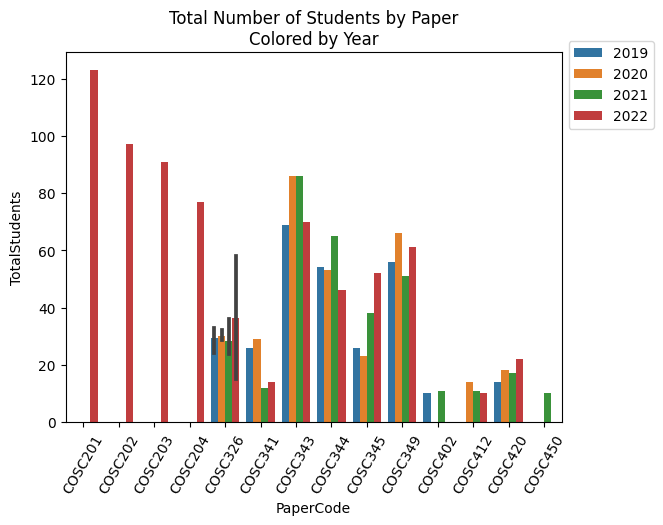

In [4]:
sns.barplot(allPapers, x="PaperCode", y="TotalStudents", hue="Year")
plt.title(f"Total Number of Students by Paper\nColored by Year")
plt.legend(bbox_to_anchor=(1, 1.05))
plt.xticks(rotation=60)
plt.show()

Separating the papers into the years we can start to spot some patterns. While we can hypothesize on these trends, we absolutely cannot state anything with certainty as we do not have enough data over enough time to be sure!

We see that `COSC301` ("Theory of Computing": a paper on formal computer science) appears to have dropped in popularity recently. This could be due to declining numbers due to COVID over this timespan, although the same trend is not present in other 300 level papers. I cannot think of any reason that this paper would decline in popularity so rapidly. I believe this is simply sampling variation and is to be expected. `COSC344` ("Databases") also seems to share this feature.

Interestingly, `COSC345` ("Software Engineering") has seen rapid growth in this timeframe. Again, this could be due to sampling variation, or it could be due to increased interest in getting hard software development skills in what is traditionally a students final year.

Finally, we can see that `COSC420` ("Advanced Artificial Intelligence / Deep Learning") has had steady growth recently. This paper, as with all 400 level papers, has a relatively low enrollment as most students don't reach 400 level papers (traditionally these are taken in an honours degree rather than a regular bachelors). This trend could be explained by the recently introduced Masters of AI, as well as an increase in interest in AI generally. `COSC343` ("Artificial Intelligence") does not seem to have the same trend (at least not to the same extent"), so perhaps the Masters of AI is the dominant factor and interest in AI is already at saturation in the student population.

Other papers are relatively flat in terms of enrollment (or don't have enough instances to tell!). 

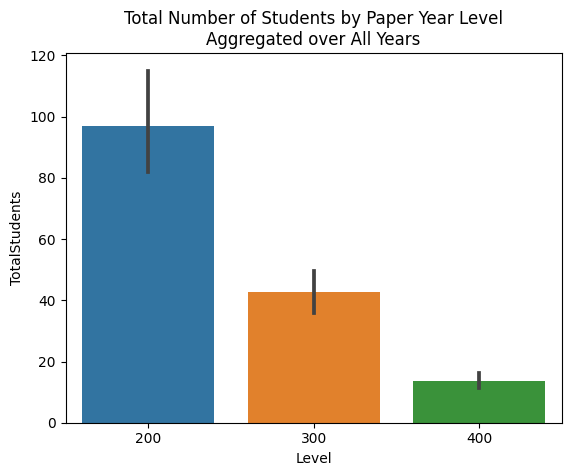

In [5]:
sns.barplot(allPapers, x="Level", y="TotalStudents")
plt.title(f"Total Number of Students by Paper Year Level\nAggregated over All Years")
plt.show()

Splitting the data by year level now, we see clearly that as the level of the paper increases, the number of students enrolled decreases. 

For the decrease from 200 to 300 level, this is probably due to students either dropping out, or students undertaking "only" a minor in computer science (requiring one 300 level paper rather than four for the major).

For the decrease from 300 to 400 level, this is almost certainly due to most students not taking an honours degree, instead graduating with a bachelors and leaving tertiary education entirely.

However, we must also consider that this data is taken in the time frame of 2019-2022: meaning the COVID-19 pandemic or other global factors could be skewing the results compared to what is typical! Perhaps more students are in higher education as a whole as businesses commence layoffs, or less students on average a continuing onto honours degrees as tech startups offer more jobs. It would require a lot more data in many more areas to say anything with confidence!

# Average Marks

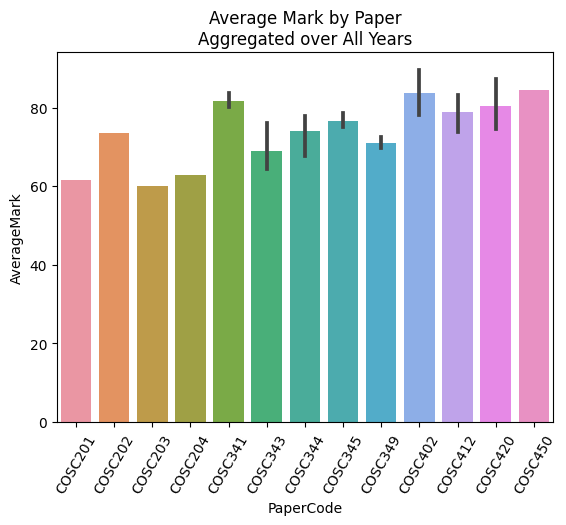

In [6]:
targetPapers = allPapers[allPapers["AverageMark"].notna()]

sns.barplot(targetPapers, x="PaperCode", y="AverageMark")
plt.title(f"Average Mark by Paper\nAggregated over All Years")
plt.xticks(rotation=60)
plt.show()

It is difficult to draw any interesting conclusions from this data directly. We cannot spot any patterns immediately from the average mark *between* papers. For example, if one paper had a far lower average mark than all others, we may be able to say that paper is more difficult (to understand or to teach!) than the other papers. We cannot see that trend immediately in this data, which is probably for the best, as it indicates the papers at the University of Otago are relatively consistently marked!

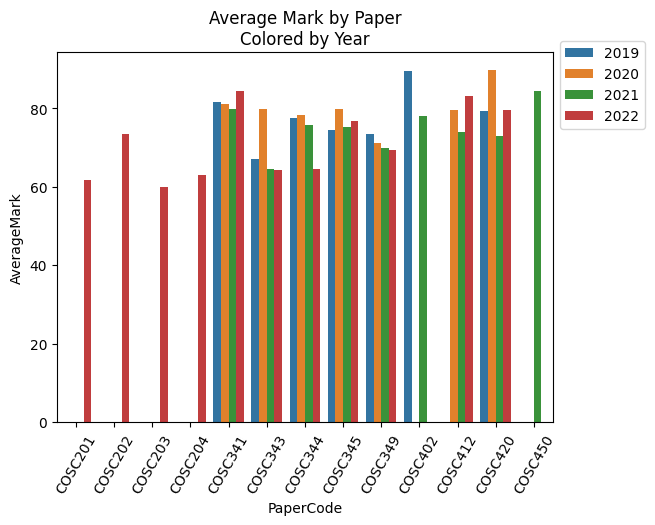

In [7]:
sns.barplot(targetPapers, x="PaperCode", y="AverageMark", hue="Year")
plt.title(f"Average Mark by Paper\nColored by Year")
plt.legend(bbox_to_anchor=(1, 1.05))
plt.xticks(rotation=60)
plt.show()

Separating papers by year we can start looking for trends across time with respect to the same paper. This has more promise than the above investigation, as we can compare marks of the same paper over time. Since the same paper should remain at the same relative "difficulty" independent of the year, any change in mark could be attributed to otago factors (i.e. not a single paper being more difficult to understand or teach!). If a mark changes significantly over time for the same paper, it may be an indication that the content of that paper is better understood by the students, such as if the contents became more popular in the student population and students are more likely to have primed themselves to learn the content. At the moment, this may be best seen with AI, where large language models are both difficult to understand but very popular, so students may now have a better understanding of that difficult content compared to previous years.

However, we do not see this trend particularly prominently in the data. The papers `COSC343` and `COSC420` (both papers on AI, where this effect may be most pronounced) do not seem to have any major differences over time. These papers do have a spike in average mark during the year 2020, which may be due to more lenient marking during the first year of COVID.

It would be ideal to have more data for the 200 level papers, as these new papers may increase in average mark over the first few years as professors become more familiar with teaching the new papers, and students that have taken the paper move on to become demonstrators for this paper. We should keep on eye on these papers in particular as the data becomes available in coming years.

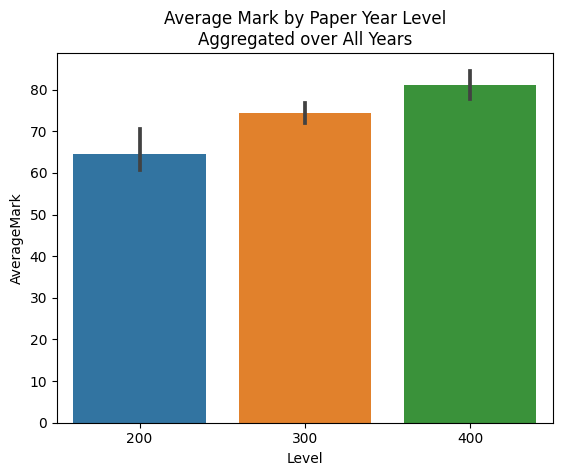

In [8]:
sns.barplot(targetPapers, x="Level", y="AverageMark")
plt.title(f"Average Mark by Paper Year Level\nAggregated over All Years")
plt.show()

Finally, looking at the average marks across year levels as a whole, it appears that average marks steadily increase as the paper level increases. This is surprising, as higher level papers are supposedly more difficult, and hence should have a lower average mark!

We can perhaps attribute this trend to the fact that as students move through the paper levels, they tend to *learn* and hence are more likely to understand domain concepts better, and thus gain better marks in these papers. The population itself may be adapting to increase average mark.

We may also attribute some of this trend to the fact that some students may drop out of the degree, and are hence not contributing their marks to the higher level papers. Although we do not have the data to state it with confidence, it seems anecdotally true that students with lower average marks are less likely to carry on to higher levels. Hence, those students that contribute below average marks are more likely to not contribute to higher level papers, and the average mark would go up. This is enforced at the 300 to 400 level boundary, where the access to the honours course requires a B+ average or higher (>75 average mark), making the selection explicit. The population is selected for higher average marks.

The error bars on these measurements may indicate that there is no change that we can claim with confidence, however!

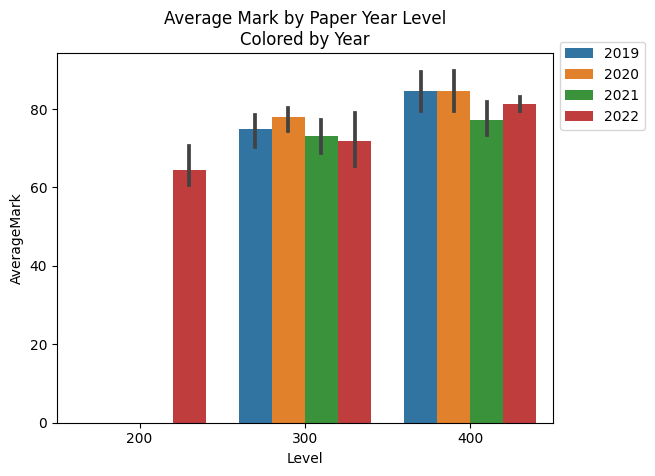

In [9]:
sns.barplot(targetPapers, x="Level", y="AverageMark", hue="Year")
plt.title(f"Average Mark by Paper Year Level\nColored by Year")
plt.legend(bbox_to_anchor=(1, 1.05))
plt.show()

Separating paper level by years, it again appears to be a roughly flat trend across time (at least, to within confidence intervals). It will be interesting to see how the 200 level papers trend as time progresses, with the new papers being used, but we will have to wait for these results.

# Analyzing Individual Papers

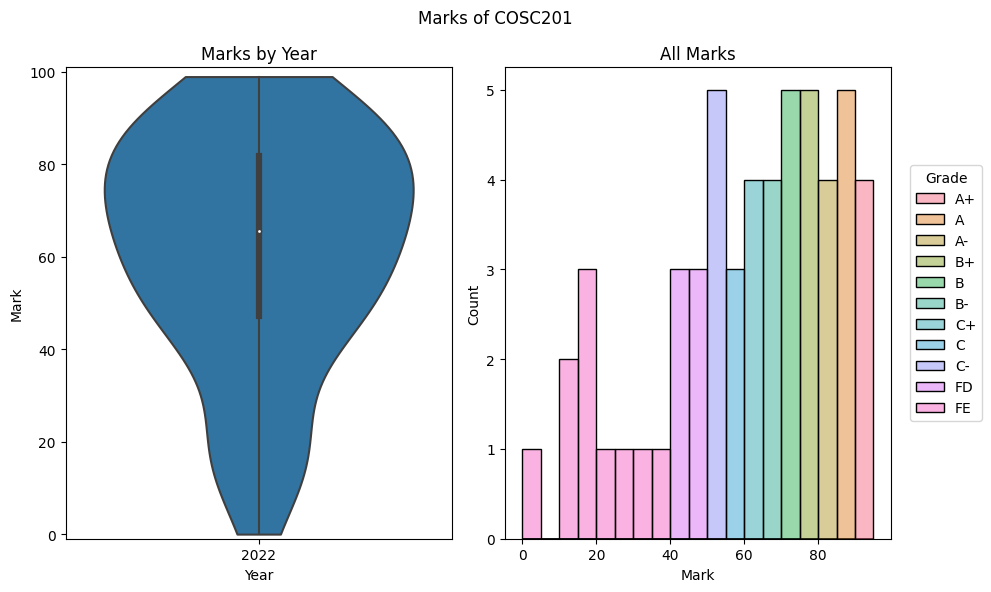

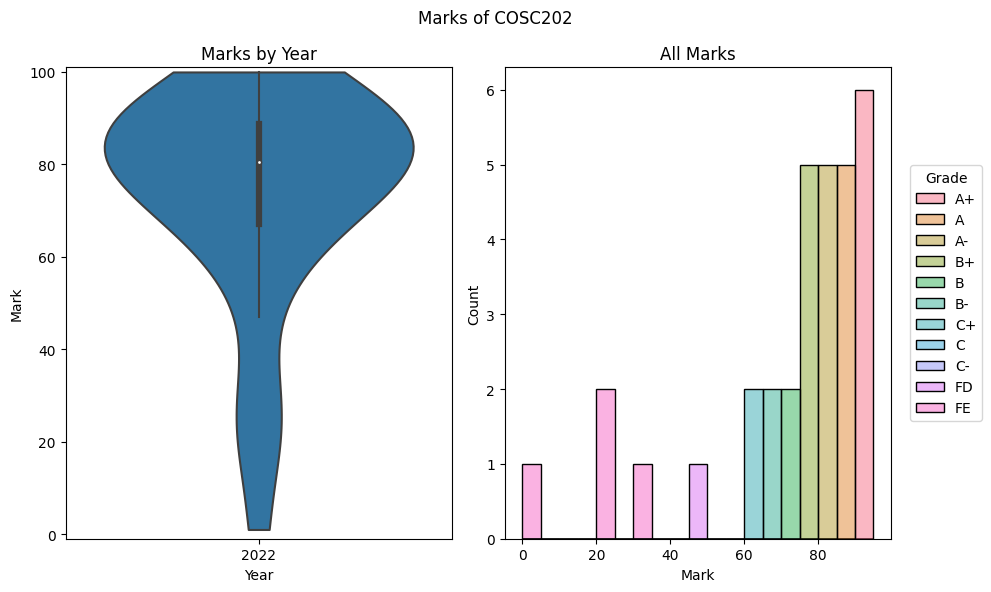

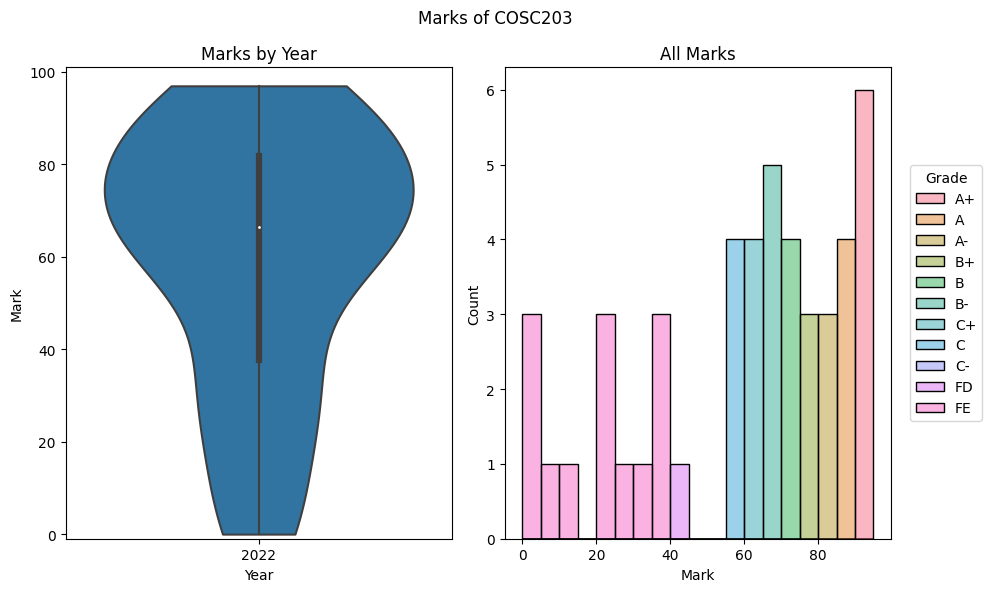

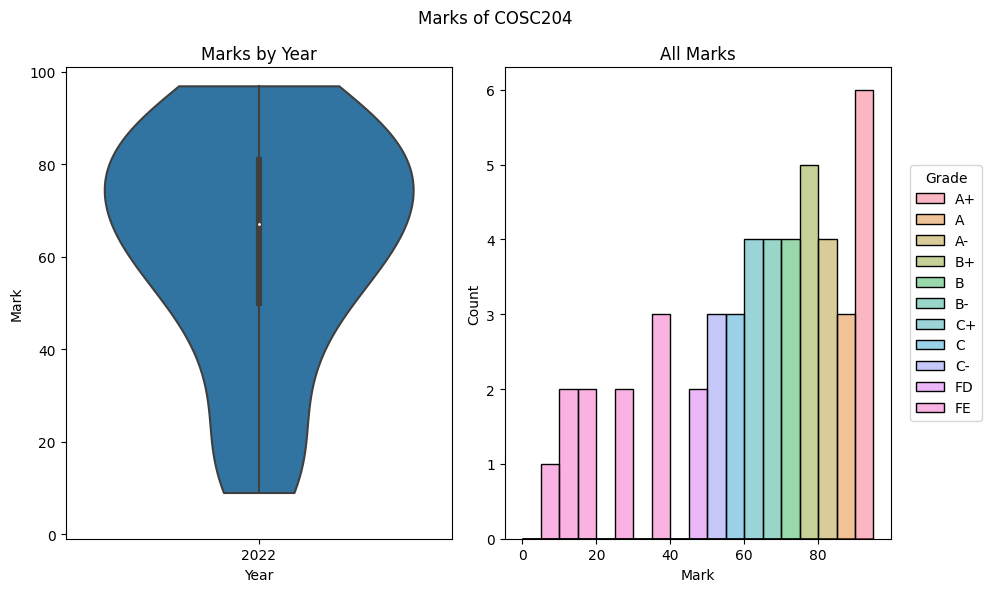

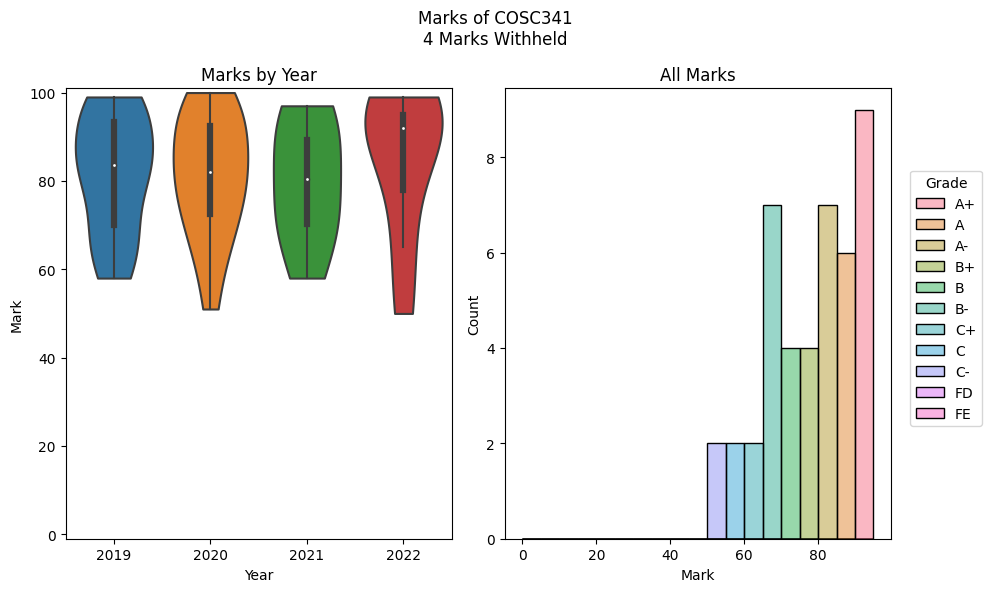

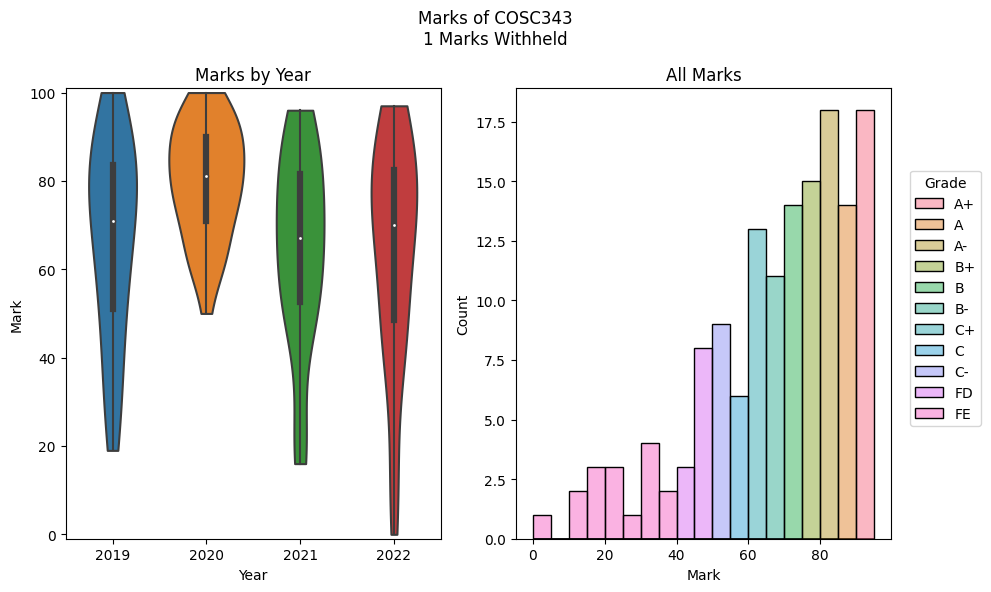

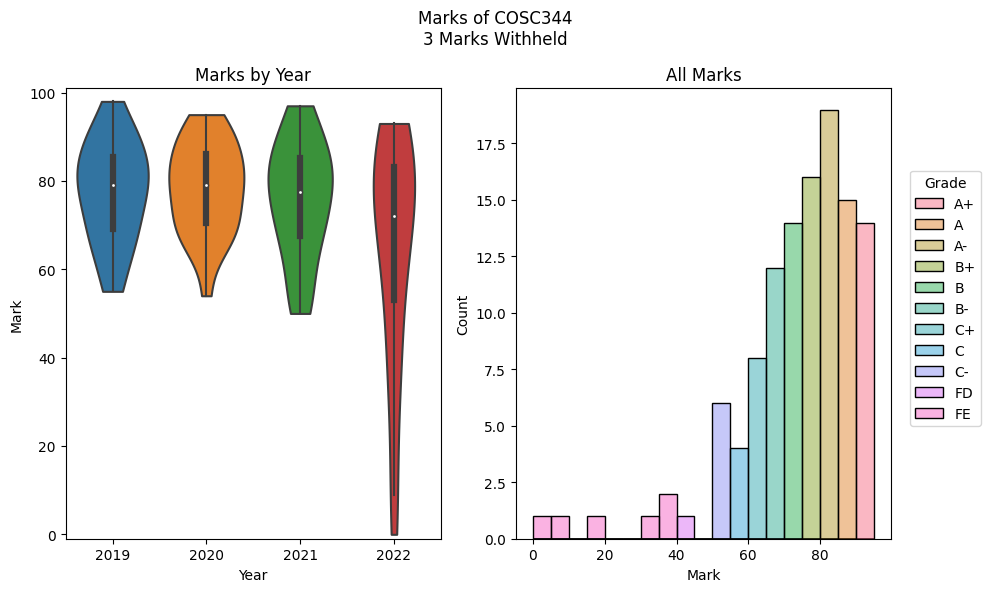

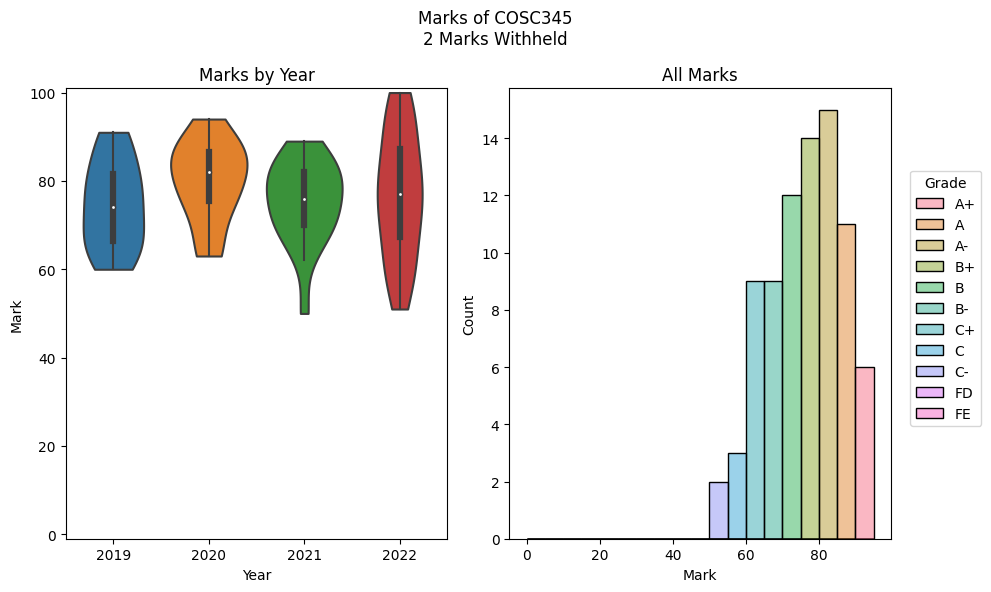

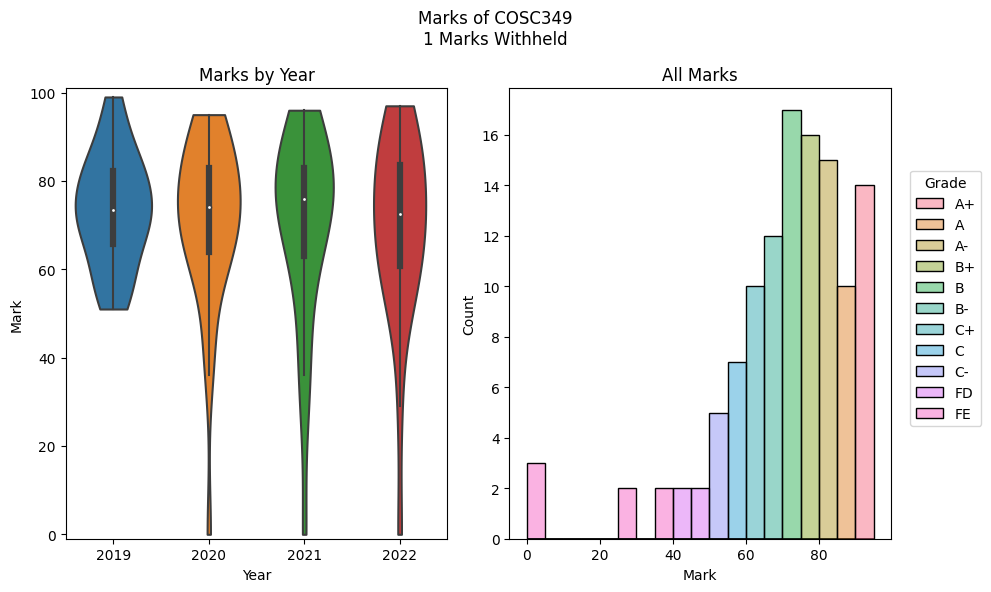

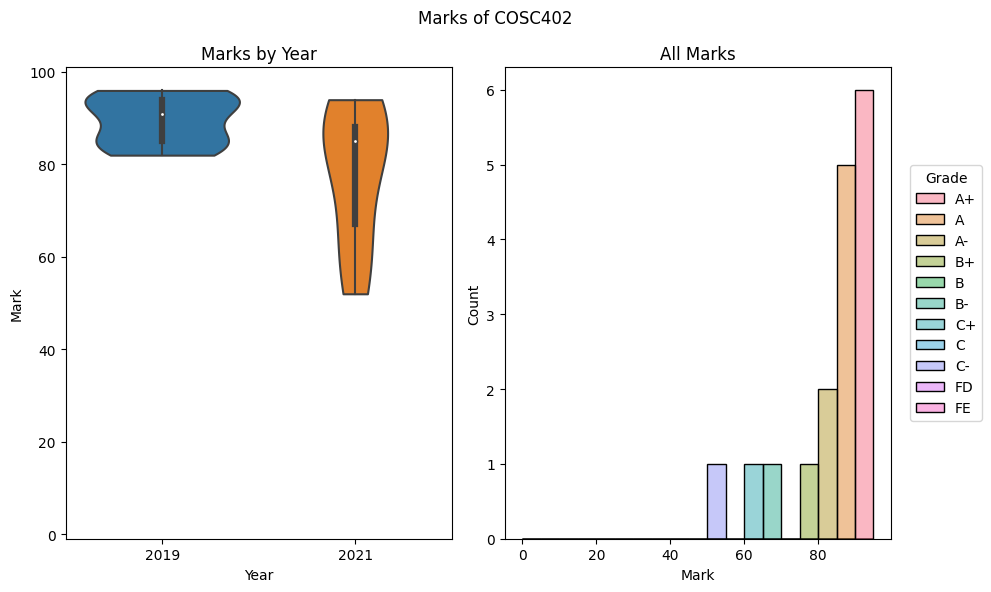

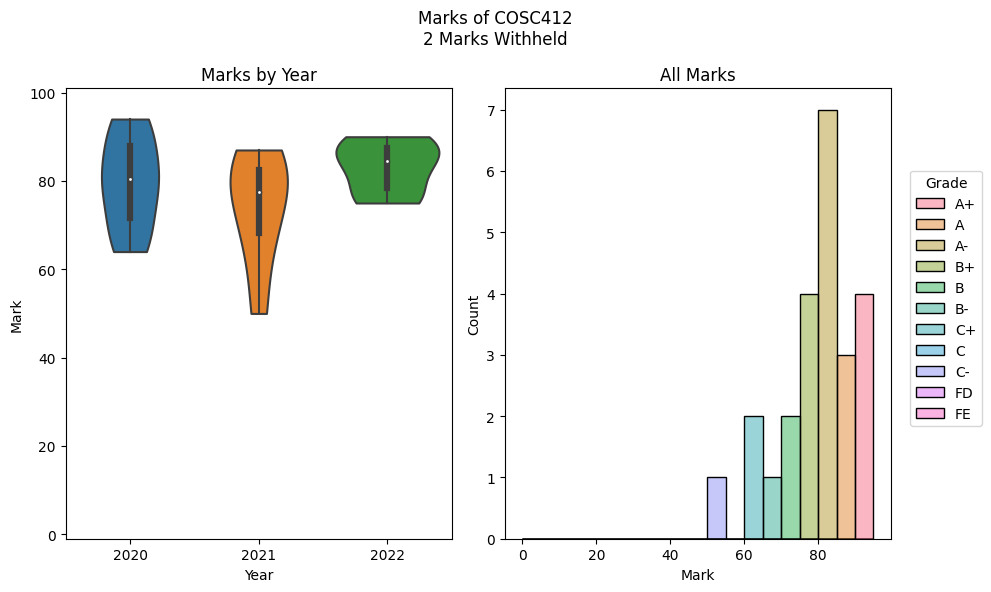

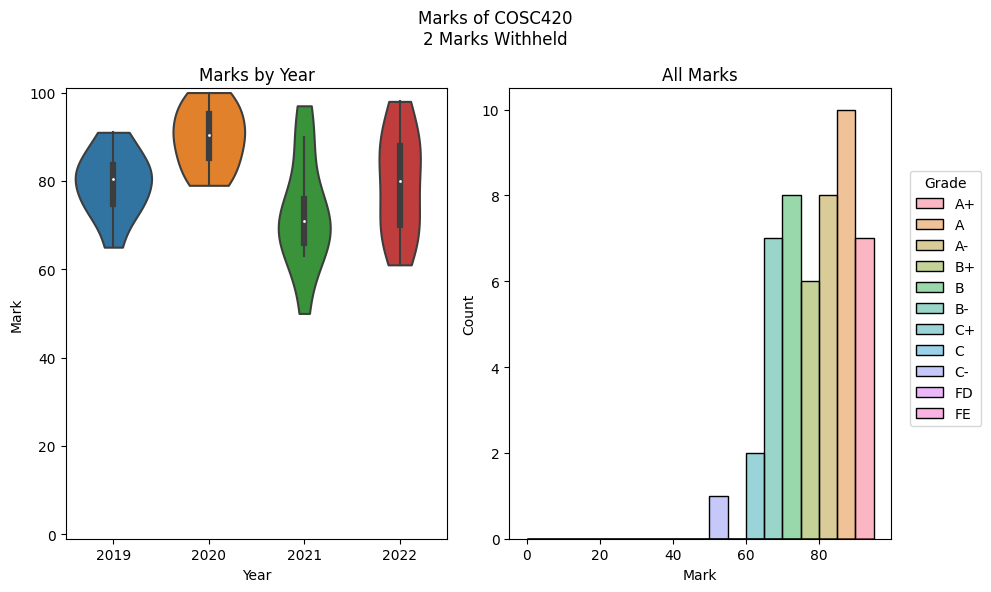

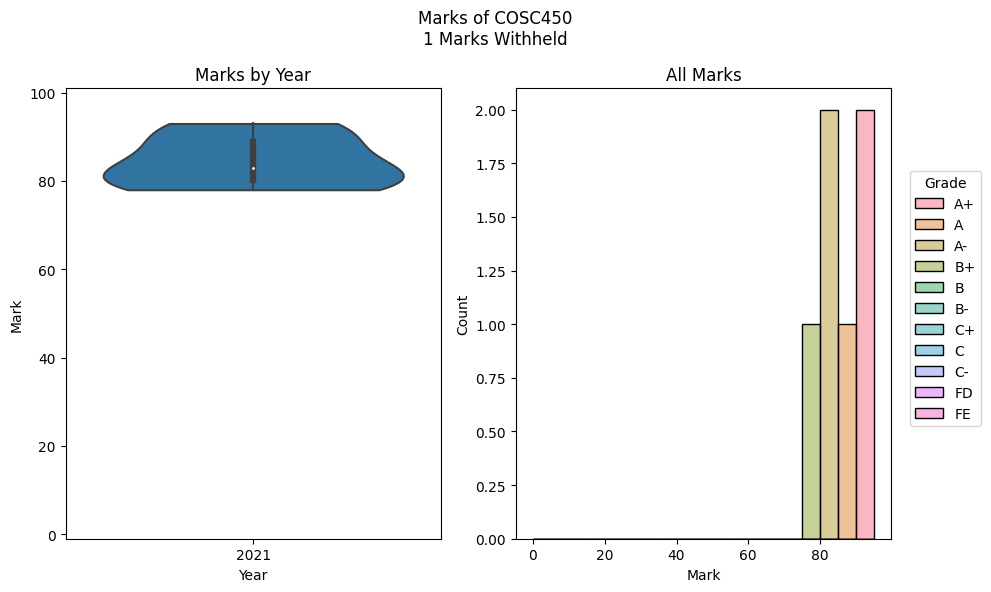

In [10]:
bins = np.arange(0,100,5)
grades = ["A+", "A", "A-", "B+", "B", "B-", "C+", "C", "C-", "FD", "FE"]
paperCodes = list(papersdfs.keys())
paperCodes.sort()

for paperCode in paperCodes:
    # Get the target dataframe, which holds all the information regarding one paper
    targetdf = papersdfs[paperCode].copy()

    # Remove all the rows (and count them!) for marks that are withheld or N/A
    targetdf["Mark"] = pd.to_numeric(targetdf["Mark"], errors="coerce")
    numWithheld = targetdf["Mark"].isna().sum()
    targetdf = targetdf.dropna()
    # If we have no rows left, just skip this paper
    if len(targetdf)==0:
        continue

    # Set up plotting by making a figure with a few axes (one for each plot we want to make)
    fig,axes = plt.subplots(1,2,figsize=(10,6))
    title = f"Marks of {paperCode}"
    if numWithheld > 0:
        title+=f"\n{numWithheld} Marks Withheld"
    fig.suptitle(title)

    # Plot the box plot of results separated by year
    sns.violinplot(targetdf, x="Year", y="Mark",  cut=0, ax=axes[0])
    axes[0].set_ylim(-1,101)
    axes[0].set_title("Marks by Year")

    # Plot the histogram of ALL marks (all years)
    sns.histplot(targetdf, x="Mark", hue="Grade", hue_order=grades, bins=bins, ax=axes[1])
    sns.move_legend(axes[1], (1.05, 0.25))
    axes[1].set_title("All Marks")


    plt.tight_layout()
    plt.show()


These are interesting results! It appears that almost all papers have a roughly consistent distribution of marks across the years (at least, consistent with that paper). The distribution of the marks aggregated over all paper instances is also mildly interesting, showing a somewhat unimodal distribution with a fairly high mean value (~80 for most papers). There is not nearly enough data for some papers to get a really good estimate of these distributions (particularly the 400 level papers). Importantly, we seem to avoid the curse of 100 level papers (unfortunately missing from this dataset), where we find many students can easily understand the content, getting high grades, while many students struggle and get low grades, leading to a bimodal distribution at the two extremes of possible grades.

Some marks are withheld by the source (the freedom of information request). The exact mark of these students are hidden when:
    - The student has a failing grade (mark<50), and
    - Fewer than 3 students have such a grade
As this can make it too easy to identify these students in a potentially embarrassing situation. Our data is therefore slightly skewed towards higher grades, and the withheld marks are noted in the plot titles. Hopefully the number of withheld marks are not enough to significantly change our analysis!

Again, it is interesting to see the two AI papers `COSC343` and `COSC420` in the year 2020. Using this visualization we can see that more than just the average mark increased, the entire distribution of marks appears to have shifted upwards! Perhaps the professor taking this class was lenient on all students during the start of the pandemic.

Note the paper `COSC326` is not included above, as this paper operates on a simple pass/fail basis and does not give a mark. This has changed in 2023, but of course we do not data for this yet.

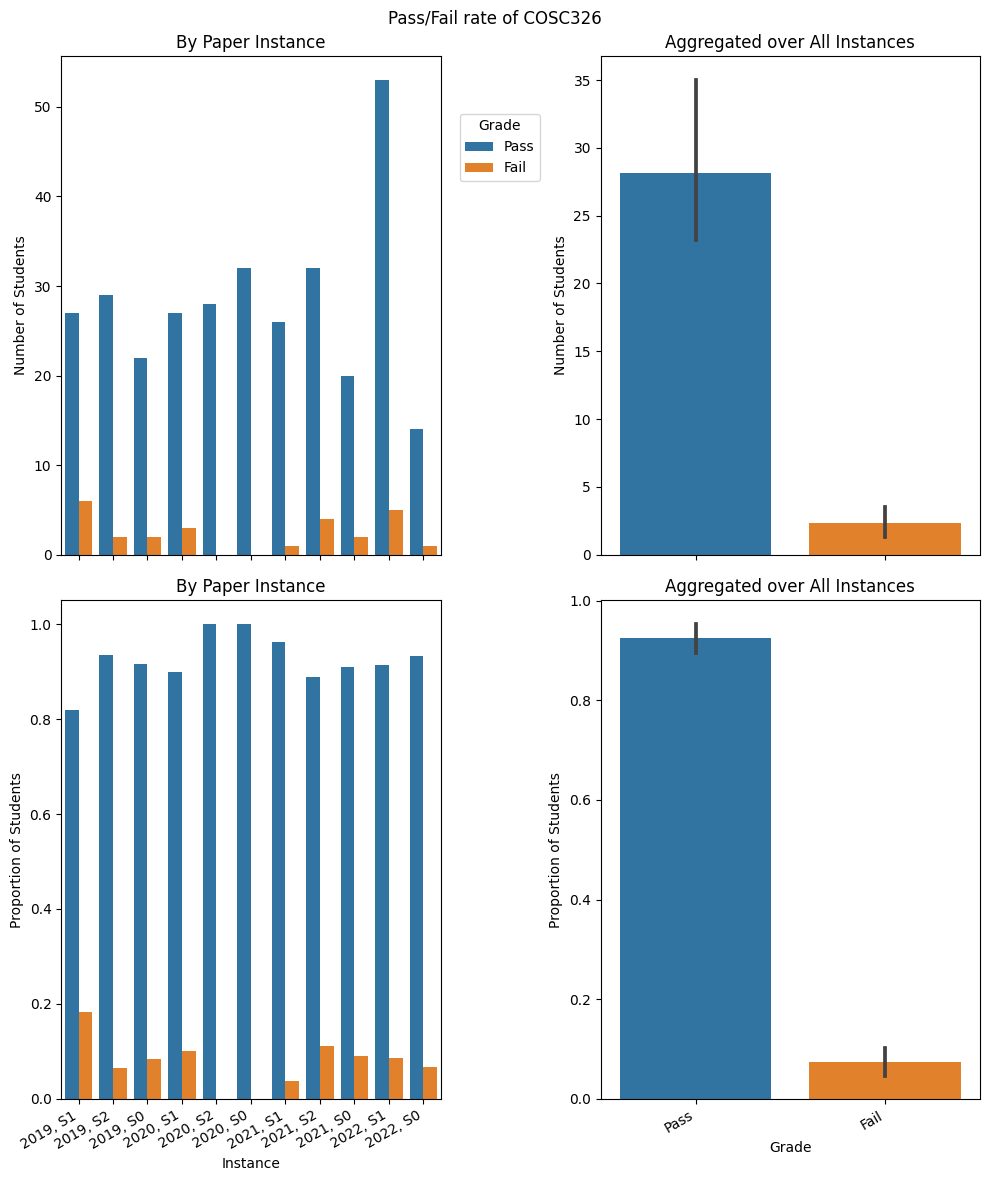

In [11]:
# Load the COSC326 dataframe
paperCode = "COSC326"
targetdf = papersdfs[paperCode]

# Normalize the number of students in each paper instance to get a proportion of pass/fail instead
targetdf["Instance"] = targetdf.apply(lambda x: f"{x['Year']}, S{x['Semester']}", axis=1)
numberOfStudentsByInstance = targetdf[["Instance", "Number of Students"]].groupby("Instance").aggregate(np.sum)
targetdf["Proportion of Students"] = targetdf.apply(lambda x: x["Number of Students"] / numberOfStudentsByInstance.loc[x["Instance"]]["Number of Students"], axis=1)
# display(targetdf)

# Set up plotting by making a figure with a few axes (one for each plot we want to make)
fig,axes = plt.subplots(2,2,figsize=(10,12))
title = f"Pass/Fail rate of {paperCode}"
fig.suptitle(title)

# Plot the box plot of results separated by year
ax = axes[0][0]
sns.barplot(targetdf, x="Instance", y="Number of Students", hue="Grade", ax=ax)
sns.move_legend(ax, (1.05, 0.75))
ax.set_title("By Paper Instance")

# Plot the histogram of ALL marks (all years)
ax = axes[0][1]
sns.barplot(targetdf, x="Grade", y="Number of Students", ax=ax)
ax.set_title("Aggregated over All Instances")

# Plot the box plot of results separated by year
ax = axes[1][0]
sns.barplot(targetdf, x="Instance", y="Proportion of Students", hue="Grade", ax=ax)
ax.legend([],[], frameon=False)
ax.set_title("By Paper Instance")

# Plot the histogram of ALL marks (all years)
ax = axes[1][1]
sns.barplot(targetdf, x="Grade", y="Proportion of Students", ax=ax)
ax.set_title("Aggregated over All Instances")


fig.autofmt_xdate()
plt.tight_layout()
plt.show()
